In [1]:
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def giniImpurity(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return np.sum(ps * (1 - ps))

In [3]:
# test giniIndex

y = [2, 1, 1, 1, 1, 1]
print(giniImpurity(y))

0.2777777777777778


In [4]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [5]:
class DecisionTree(BaseEstimator):

    def __init__(self, min_samples_split=5, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats # for random forest, choosing a subset of features
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(
            self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to the gini gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._gini_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _gini_gain(self, y, X_column, split_thresh):
        # parent
        parent_gini_impurity = giniImpurity(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        g_l, g_r = giniImpurity(y[left_idxs]), giniImpurity(y[right_idxs])
        child_gini_impurity = (n_l / n) * g_l + (n_r / n) * g_r

        # gini gain is difference in loss before vs. after split
        gg = parent_gini_impurity - child_gini_impurity
        return gg

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [6]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from sklearn.model_selection import cross_val_score

dec_clf = DecisionTree(max_depth=11)

cross_val_score(dec_clf, X_train, y_train, cv=2, scoring='accuracy')

array([0.9122807 , 0.93832599])

In [8]:
from sklearn.model_selection import cross_val_predict

In [9]:
y_train_pred = cross_val_predict(dec_clf, X_train, y_train, cv=2)

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
confusion_matrix(y_train, y_train_pred)

array([[154,  16],
       [ 22, 263]])

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [13]:
precision_score(y_train, y_train_pred)

0.942652329749104

In [14]:
recall_score(y_train, y_train_pred)

0.9228070175438596

In [15]:
f1_score(y_train, y_train_pred)

0.9326241134751773

In [16]:
from sklearn.metrics import roc_curve

In [17]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

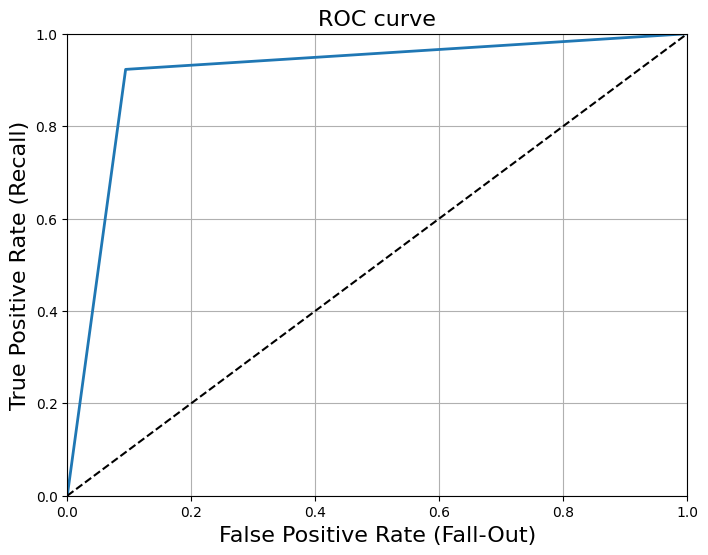

In [18]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve", fontsize=16)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.9143446852425181

In [20]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [21]:
cols = ["Pregnancies" ,"Glucose" ,"BloodPressure" ,"SkinThickness" ,"Insulin" ,"BMI" ,"DiabetesPedigreeFunction" ,"Age" ,"Outcome"]
url = "https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv"

diabetes_data = pd.read_csv(url, skiprows=9, header=None, names=cols)
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
diabetes_data.shape

(768, 9)

In [23]:
# X = diabetes_data[['Glucose','BMI']]
X = diabetes_data[cols[:-1]]
y = diabetes_data[cols[-1]]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, stratify=y, random_state=42)


y_train = y_train.values
y_test = y_test.values

In [24]:
# from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

dec_clf = DecisionTree(max_depth=12)

# cv_results = cross_validate(dec_clf, X_train, y_train, cv=2, scoring='accuracy', return_estimator=True)
# clf = cv_results["estimator"][1]


scores =  cross_val_score(dec_clf, X_train, y_train, cv=2, scoring='accuracy')

In [25]:
 def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [26]:
display_scores(scores)

Scores: [0.69942197 0.70434783]
Mean: 0.7018848957024378
Standard deviation: 0.0024629303845187245


In [27]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(dec_clf, X_train, y_train, cv=2)

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_train_pred)
print(cm)

[[342 108]
 [104 137]]


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [30]:
precision_score(y_train, y_train_pred)

0.5591836734693878

In [31]:
recall_score(y_train, y_train_pred)

0.5684647302904564

In [32]:
f1_score(y_train, y_train_pred)

0.5637860082304527

In [33]:
from sklearn.metrics import roc_curve

In [34]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

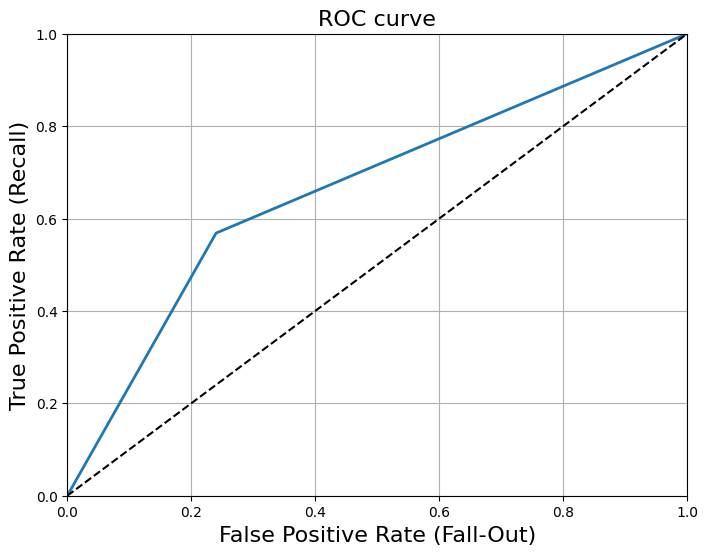

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve", fontsize=16)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.6642323651452282

In [37]:
clf = DecisionTree(max_depth=14)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
print ("Accuracy:", acc)

Accuracy: 0.7922077922077922


In [38]:
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

X = diabetes_data[cols[:-1]]
y = diabetes_data[cols[-1]]

best = 0

for train_index, test_index in sss.split(X, y):
   strat_train_X = X.loc[train_index].values
   strat_train_y = y.loc[train_index].values

   strat_test_X = X.loc[test_index].values
   strat_test_y = y.loc[test_index].values

   clf = DecisionTree(max_depth=9)
   clf.fit(strat_train_X, strat_train_y)

   y_pred = clf.predict(strat_test_X)
   acc = accuracy(strat_test_y, y_pred)
   print ("Accuracy:", acc)
   print()

Accuracy: 0.7337662337662337

Accuracy: 0.7142857142857143

